In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

In [3]:
#set colormap for id
cmap = plt.cm.hsv
cmap.set_under(color='black')  

cmap_prism = plt.cm.prism
cmap_prism.set_under(color='black')

In [4]:
basedir_output = 'bach_outputs/'
basedir_input = '../../data/ICIAR2018_BACH/breasthistology/'

traindir_output = os.path.join(basedir_output,'train')
traindir_input = os.path.join(basedir_input,'Training_data')

testdir_output = os.path.join(basedir_output,'test')
testdir_input = os.path.join(basedir_input,'Test_data')

type_list = ['Normal','Benign','InSitu','Invasive']

trainlist_input = glob(os.path.join(traindir_input, '*/*.tif'))

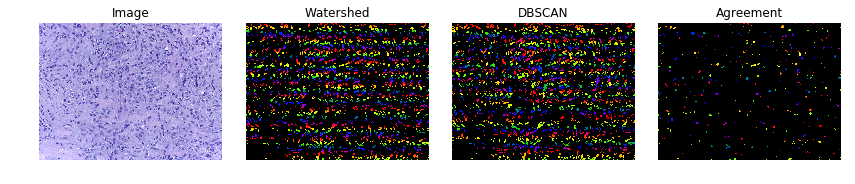

In [5]:
def showtrio(myid, mydir, mydir_orig):
    image = glob(os.path.join(mydir_orig, '%i.tif' % myid))
    assert(len(image)==1)

    water = glob(os.path.join(mydir, 'w*data_%i.tif.npy' % myid))
    dbscan = glob(os.path.join(mydir, 'd*data_%i.tif.npy' % myid))
    agree = glob(os.path.join(mydir, 'a*data_%i.tif.npy' % myid))
    filelist = water+dbscan+agree
    assert(len(filelist)==3)
    
    #Label the agree map
    labeled = np.multiply(np.load(water[0]), np.load(agree[0]))
    
    fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(plt.imread(image[0]))
    ax[0].set_title('Image')
    ax[1].imshow(np.load(filelist[0]), cmap=cmap_prism, vmin=0.001)
    ax[1].set_title('Watershed')
    ax[2].imshow(np.load(filelist[1]), cmap=cmap_prism, vmin=0.001)
    ax[2].set_title('DBSCAN')
    ax[3].imshow(labeled, cmap=cmap_prism, vmin=0.001)
    ax[3].set_title('Agreement')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return water[0], dbscan[0], agree[0]
watershed, dbscan, agreement = showtrio(15,testdir_output, testdir_input)

DATA NOTE: 69 Benign excluded because not readable

In [6]:
def get_cl_metrics(labeled):
    unique, counts = np.unique(labeled[labeled>0], 
                               return_counts=True)
    median = np.percentile(counts, 50)
    mean = np.mean(counts)
    std = np.std(counts)
    lq = np.percentile(counts, 25)
    uq = np.percentile(counts, 75)
    ncl = unique.shape[0]
    return median, lq, uq, ncl, mean, std

In [7]:
def build_train_df(thr=5):
    df_train = pd.DataFrame()
    df_train['path_input'] = trainlist_input
    df_train['id'] = df_train['path_input'].str.split('/').str[-1].str.split('.').str[0]
    df_train['class']=df_train['path_input'].str.split('/').str[-2]
    df_train['id'] = df_train['id']+'_'+df_train['class'].str[0:3]
    df_train.set_index('id', inplace=True)
    uhoh=[]

    for i in df_train.index:
        myclass = df_train.loc[i,'class']
        myid = i.split('_')[0]
        watershed_list = glob(os.path.join(traindir_output, 
                                      myclass+'/w*_'+myid+'.tif.npy'))
        dbscan_list = glob(os.path.join(traindir_output, 
                                   myclass+'/d*_'+myid+'.tif.npy'))
        agreement_list = glob(os.path.join(traindir_output, 
                                      myclass+'/a*_'+myid+'.tif.npy'))

        if len(watershed_list) == 1:
            watershed_o = np.load(watershed_list[0])
            watershed = np.multiply(watershed_o,watershed_o>thr)
        if len(dbscan_list) == 1:
            dbscan_o = np.load(dbscan_list[0])
            dbscan = np.multiply(dbscan_o,dbscan_o>thr)
        if len(agreement_list) == 1:
            agreement = np.load(agreement_list[0])

        labeled_agree = np.multiply(watershed,agreement)

        try:
            df_train.loc[i,'a_MED'], df_train.loc[i,'a_LQ'], df_train.loc[i,'a_UQ'], df_train.loc[i,'a_CLCT'], df_train.loc[i,'a_MEAN'], df_train.loc[i,'a_STD'] = get_cl_metrics(labeled_agree)
            df_train.loc[i,'w_MED'], df_train.loc[i,'w_LQ'], df_train.loc[i,'w_UQ'], df_train.loc[i,'w_CLCT'], df_train.loc[i,'w_MEAN'], df_train.loc[i,'w_STD'] = get_cl_metrics(watershed)
            df_train.loc[i,'d_MED'], df_train.loc[i,'d_LQ'], df_train.loc[i,'d_UQ'], df_train.loc[i,'d_CLCT'], df_train.loc[i,'d_MEAN'], df_train.loc[i,'d_STD'] = get_cl_metrics(dbscan)
        except:
            print('uhoh '+i)
            uhoh.append(i)
    print(uhoh)
    return df_train

df_train = build_train_df()

[]


In [8]:
df_train['difAD_CLCT'] = df_train['d_CLCT']-df_train['a_CLCT']
df_train['a_IQR'] = df_train['a_UQ']-df_train['a_LQ']
df_train['w_IQR'] = df_train['w_UQ']-df_train['w_LQ']
df_train['d_IQR'] = df_train['d_UQ']-df_train['d_LQ']

In [9]:
df_train['Carcinoma'] = (df_train['class']=='InSitu') | (df_train['class']=='Invasive')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


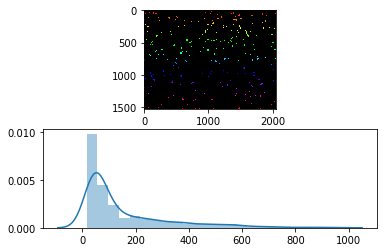

In [11]:
#Quantify distribution of cluster sizes
watershed = np.load(watershed)
agreement = np.load(agreement)

labeled_agree = np.multiply(watershed, agreement)

unique, counts = np.unique(labeled_agree[labeled_agree>0], 
                               return_counts=True)

plt.subplot(2,1,1)
plt.imshow(labeled_agree, cmap=cmap, vmin=0.01)
plt.subplot(2,1,2)
sns.distplot(counts, norm_hist=False)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


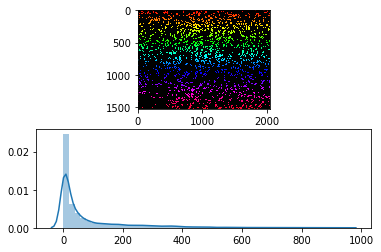

In [12]:
unique, counts = np.unique(watershed[watershed>0], 
                               return_counts=True)

plt.subplot(2,1,1)
plt.imshow(watershed, cmap=cmap, vmin=0.01)
plt.subplot(2,1,2)
sns.distplot(counts, norm_hist=False)

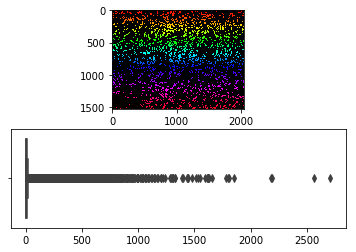

In [13]:
dbscan = np.load(dbscan)
unique, counts = np.unique(dbscan[dbscan>0], 
                               return_counts=True)

plt.subplot(2,1,1)
plt.imshow(dbscan, cmap=cmap, vmin=0.01)
plt.subplot(2,1,2)
sns.boxplot(counts)

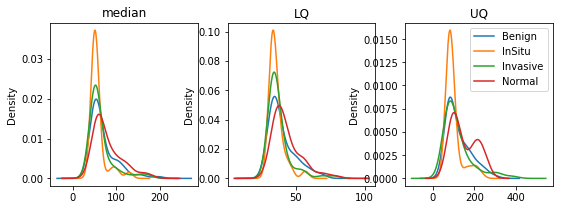

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
a = df_train.groupby('class').a_MED.plot(kind='kde', ax=ax[0], title='median')
a = df_train.groupby('class').a_LQ.plot(kind='kde', ax=ax[1], title='LQ')
a = df_train.groupby('class').a_UQ.plot(kind='kde', ax=ax[2], title='UQ')
plt.legend()

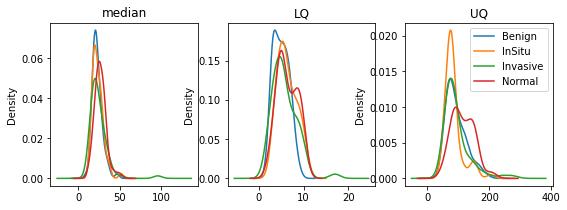

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
a = df_train.groupby('class').w_MED.plot(kind='kde', ax=ax[0], title='median')
a = df_train.groupby('class').w_LQ.plot(kind='kde', ax=ax[1], title='LQ')
a = df_train.groupby('class').w_UQ.plot(kind='kde', ax=ax[2], title='UQ')
plt.legend()

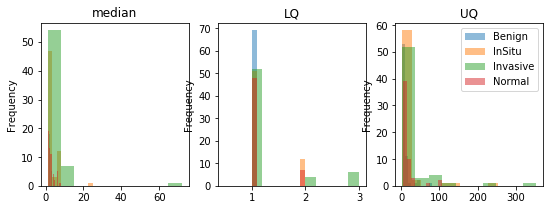

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
a = df_train.groupby('class').d_MED.plot(kind='hist', ax=ax[0], title='median', alpha=0.5)
a = df_train.groupby('class').d_LQ.plot(kind='hist', ax=ax[1], title='LQ', alpha=0.5)
a = df_train.groupby('class').d_UQ.plot(kind='hist', ax=ax[2], title='UQ', alpha=0.5)
plt.legend()

# Functions for ML

In [273]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def pca_lda(X,y,target_names):

    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)
    print('pca')
    print(X_r.shape)

    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(X, y).transform(X)
    print('lda')
    print(X_r2.shape)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))

    plt.figure()
    color_set = ['navy', 'turquoise', 'darkorange', 'purple']
    colors = color_set[0:len(np.unique(y))]

    lw = 2

    for color, i, target_name in zip(colors, np.unique(y), target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False)
    plt.title('PCA')
        
    plt.figure()
    
    print('shape')
    print(X_r2.shape)
    
    if X_r2.shape[-1]>1:
        print('good')
        for color, i, target_name in zip(colors, np.unique(y), target_names):
            plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                            label=target_name)
    else:
        print('elsing')
        #np.concatenate(X_r2, np.ones(X_r2.shape))
        print('new')
        print(X_r2.shape)
        for color, i, target_name in zip(colors, np.unique(y), target_names):
            plt.plot(X_r2[y == i], 'o', alpha=.8, color=color,
                            label=target_name)

    plt.legend(loc='best', shadow=False)
    plt.title('LDA')

    plt.show()
    

In [274]:
#CITE: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names):
    coef = classifier.coef_.ravel()
    top_coefficients = np.argsort(coef)

    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(len(feature_names)), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [275]:
#CITE: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [276]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

def do_recursive_fs(X,y):
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear")
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
                  scoring='accuracy')
    rfecv.fit(X, y)

    

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.title("Optimal number of features : %d" % rfecv.n_features_)
    plt.show()
    
    return rfecv

pca
(249, 2)
lda
(249, 2)
explained variance ratio (first two components): [0.44509819 0.16086747]
shape
(249, 2)
good


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


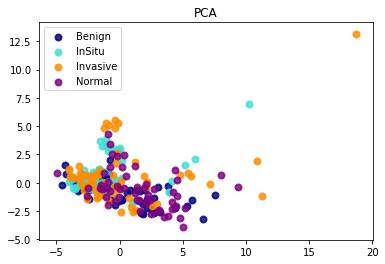

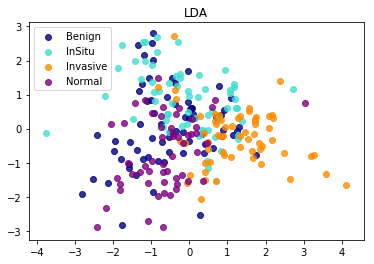

In [277]:
X=df_train.iloc[:,2:-1]
y_names=df_train['class']
categories = y_names.value_counts().index

feature_names = df_train.columns[2:-1]

from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
le.fit(categories)

X_kesh = StandardScaler().fit_transform(X)
y_kesh = le.transform(y_names)

pca_lda(X_kesh, y_kesh, categories)

pca
(131, 2)
lda
(131, 1)
explained variance ratio (first two components): [0.45835411 0.15174079]
shape
(131, 1)
elsing
new
(131, 1)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


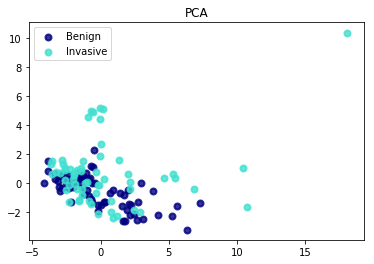

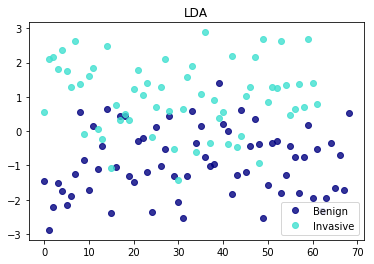

In [278]:
df_ex = df_train[(df_train['class'] == 'Benign') | (df_train['class'] == 'Invasive')]
            
X_ex=df_ex.iloc[:,2:-1]
y_names_ex = df_ex['class']
categories_ex = y_names_ex.value_counts().index

le_ex = LabelEncoder()
le_ex.fit(y_names_ex.value_counts().index)

X_ex = StandardScaler().fit_transform(X_ex)
y_ex = le_ex.transform(y_names_ex)
pca_lda(X_ex, y_ex, categories_ex)

pca
(249, 2)
lda
(249, 1)
explained variance ratio (first two components): [0.44509819 0.16086747]
shape
(249, 1)
elsing
new
(249, 1)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


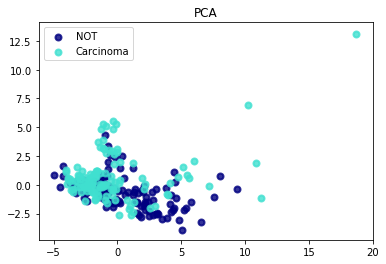

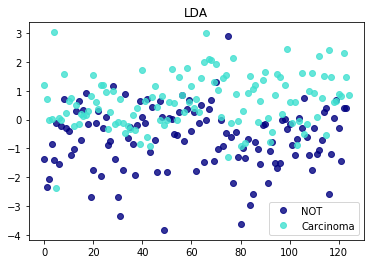

In [279]:
X_carc=df_train.iloc[:,2:-1]
y_carc = df_train['Carcinoma']*1

categories_carc = ['NOT','Carcinoma']

X_carc = StandardScaler().fit_transform(X_carc)

pca_lda(X_carc,y_carc,categories_carc)

In [280]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# X -> features, y -> label

def dosvm(X,y,categories, feature_names=None):

    # dividing X, y into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

    # training a linear SVM classifier
    from sklearn.svm import SVC
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
    svm_predictions = svm_model_linear.predict(X_test)

    # model accuracy for X_test  
    accuracy = svm_model_linear.score(X_test, y_test)
    print('Accuracy = %f' % accuracy)

    # creating a confusion matrix
    cm = confusion_matrix(y_test, svm_predictions)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=categories,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=categories, normalize=True,
                          title='Normalized confusion matrix')
    
    rec_fs = do_recursive_fs(X, y)
    new_X = rec_fs.transform(X)
    
    if feature_names is not None:
        plot_coefficients(svm_model_linear, feature_names)
    else:
        new_feature_names = None
    
    print(new_X.shape)
    print(X.shape)
    
    if new_X.shape[-1] == X.shape[-1]:
        print('Feature reduction not recommended')
    else:
        print('Feature reduction recommended')
    return new_X

Accuracy = 0.492063


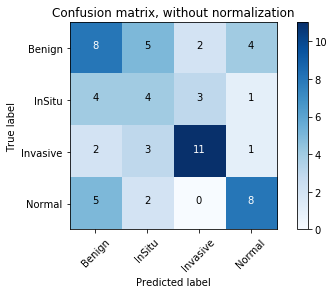

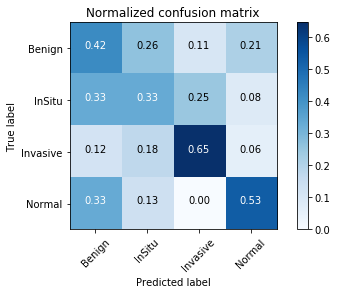

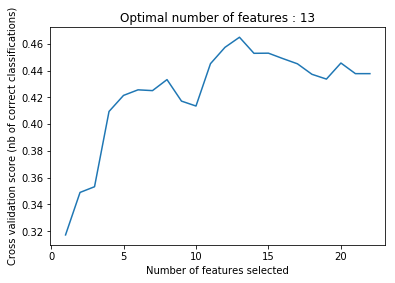

(249, 13)
(249, 22)
Feature reduction recommended


In [283]:
X_kesh_rf = dosvm(X_kesh,y_kesh, categories)

Accuracy = 0.507937


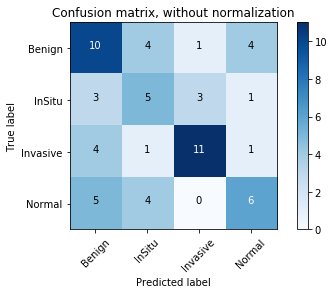

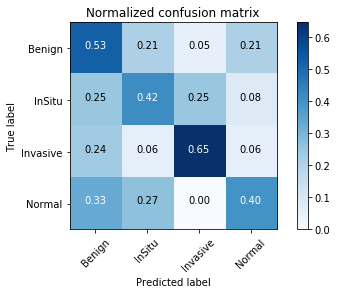

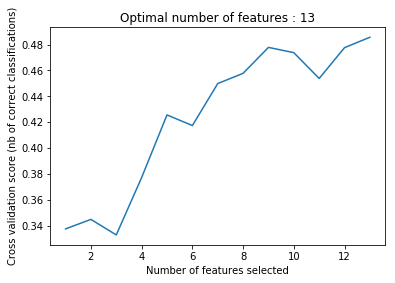

(249, 13)
(249, 13)
Feature reduction not recommended


In [265]:
X_kesh_rfrf = dosvm(X_kesh_rf, y_kesh, categories)

Accuracy = 0.727273


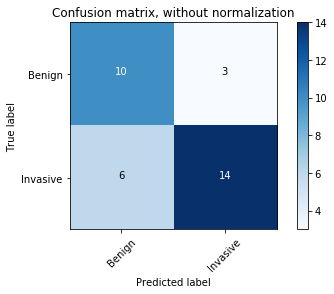

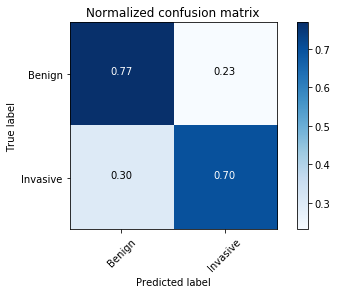

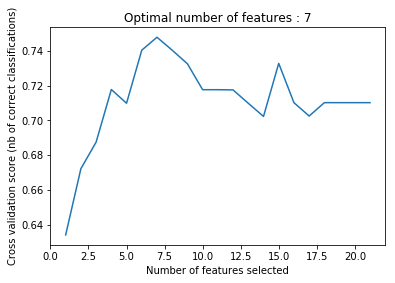

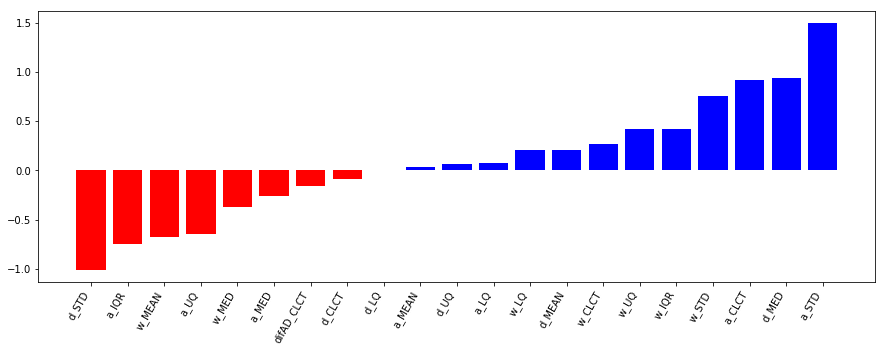

(131, 7)
(131, 21)
Feature reduction recommended


In [266]:
X_ex_rf = dosvm(X_ex[:,:-1],y_ex, categories_ex, feature_names=feature_names[:-1])

Accuracy = 0.727273


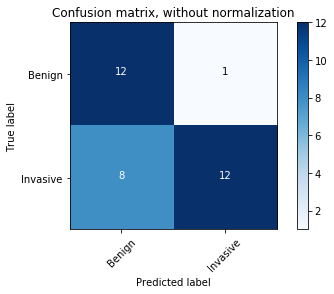

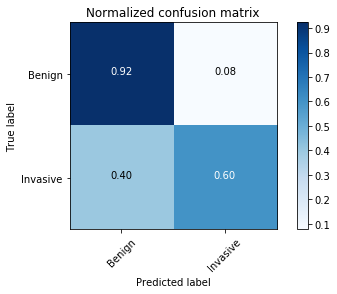

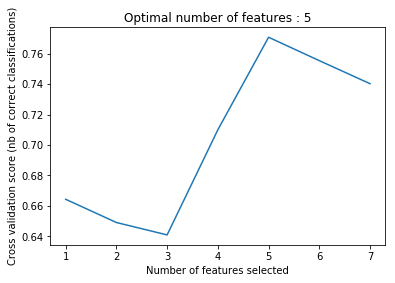

(131, 5)
(131, 7)
Feature reduction recommended


In [267]:
X_ex_rfrf = dosvm(X_ex_rf, y_ex, categories_ex)

Accuracy = 0.761905


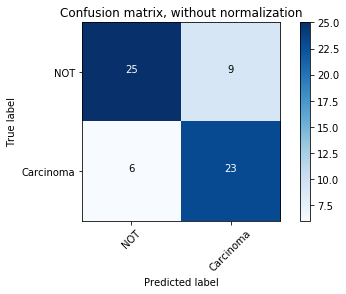

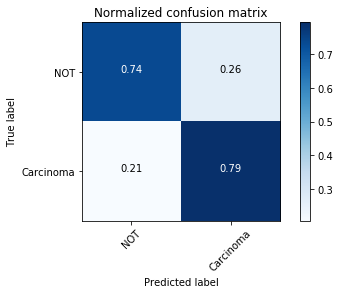

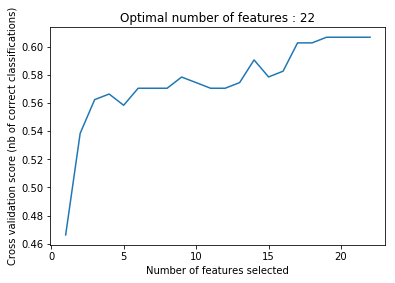

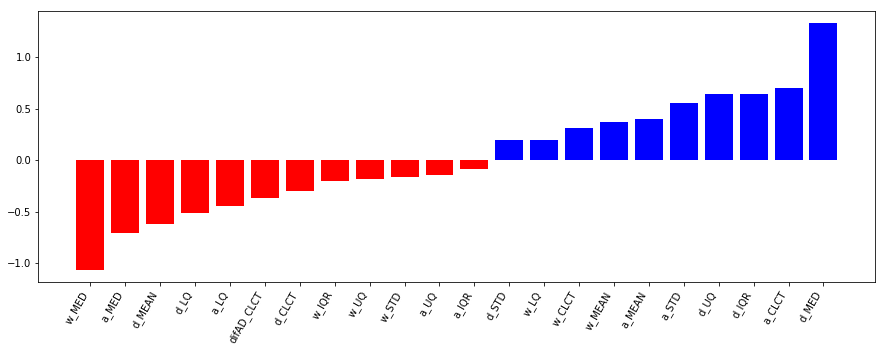

(249, 22)
(249, 22)
Feature reduction not recommended


In [270]:
X_carc_rf = dosvm(X_carc,y_carc, categories_carc, feature_names=feature_names)